### Prepare circuit with parameters

In [25]:
import numpy as np
from math import sin, cos, pi, asin
from scipy.linalg import expm
import matplotlib.pyplot as plt

I  = np.array([[1,0],[0,1]]) # 2*2
H  = 2**(-0.5)*np.array([[1,1],[1,-1]]) # 2*2
F  = 0.5*np.array([[1,1,1,1],[1,1j,-1,-1j],[1,-1,1,-1],[1,-1j,-1,1j]]).transpose().conjugate() # 4*4
B0 = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]) # 4*4 # |00><00|
B1 = np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]]) # 4*4 # |01><01|
B2 = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]]) # 4*4 # |10><10|
B3 = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]]) # 4*4 # |11><11|
s0 = np.array([[1],[0]])
s1 = np.array([[0],[1]])

def getAB(a,b,c,d):
    return np.array([[a,b],[b,c]]), np.array([[1],[d]])

def getRealX(A,B):
    x = np.linalg.inv(A) @ B
    return x/(x[0]**2+x[1]**2)**0.5

def mKron(*args):
    P = np.array([[1]])
    for M in args:
        P = np.kron(P,M)
    return P

def Ry(theta):
    return np.array([[cos(theta/2), -sin(theta/2)],[sin(theta/2), cos(theta/2)]])

def myHHL(A): # 4*4 -> 16*16
    circ_H   = mKron(I,H,H,I)
    circ_CU1 = mKron(I, I, mKron(np.array([[1,0],[0,0]]),I)+mKron(np.array([[0,0],[0,1]]),expm(1j*A)) )    # CU1: |0><0|I + |1><1|e^(iA) 
    circ_CU2 = mKron(I, mKron(np.array([[1,0],[0,0]]),I,I)+mKron(np.array([[0,0],[0,1]]),I,expm(1j*A*2)) ) # CU2: |0><0|II + |1><1|Ie^(iA)
    circ_F   = mKron(I,F,I)
    #return circ_F @ circ_CU2 @ circ_CU1 @ circ_H # debug

    CR0 = mKron(Ry(0),B0)              + mKron(I,B1+B2+B3) # CR0: Ry0|00><00| + I(|01><01|+|10><10|+|11><11|)
    CR1 = mKron(Ry(2*asin(2/pi)),B1)   + mKron(I,B0+B2+B3) # CR1: Ry1|01><01| + I(|00><00|+|10><10|+|11><11|)
    CR2 = mKron(Ry(2*asin(1/pi)),B2)   + mKron(I,B0+B1+B3) # CR2: Ry2|10><10| + I(|00><00|+|01><01|+|11><11|)
    CR3 = mKron(Ry(2*asin(2/pi/3)),B3) + mKron(I,B0+B1+B2) # CR3: Ry3|11><11| + I(|00><00|+|01><11|+|10><10|)
    circ_CR  = mKron(CR3@CR2@CR1@CR0,I)
    #return circ_CR @ circ_F @ circ_CU2 @ circ_CU1 @ circ_H # debug
    
    circ_FH  = circ_F.transpose().conjugate()
    circ_CU2H= circ_CU2.transpose().conjugate()
    circ_CU1H= circ_CU1.transpose().conjugate()
    circ_HH  = circ_H.transpose().conjugate()
    circ = circ_HH @ circ_CU1H @ circ_CU2H @ circ_FH @ circ_CR @ circ_F @ circ_CU2 @ circ_CU1 @ circ_H
    assert checkUnitary(circ)[0]==True
    return circ

def qkHHL(A):
    return mKron(H,H,H,H)

def initializeB(B): # 2*1 -> 16*1
    B = B/(B[0]**2+B[1]**2)**0.5
    return mKron(np.array([[1],[0],[0],[0],[0],[0],[0],[0]]),B)

def getPredX(A,B,HHL): # 4*4,2*1 -> 2*1
    predTotalState = HHL(A) @ initializeB(B); #roundPrint(predTotalState); # raise # debug
    predX = predTotalState[8:10]
    length = (abs(predX[0])**2+abs(predX[1])**2)**0.5
    return predX/length if length!=0 else predX

def fidelity(realX, predX):
    fp = (realX.transpose().conjugate() @ predX)[0][0]
    fn = (realX.transpose().conjugate() @ -predX)[0][0]
    return abs(fp), abs(fn)

def loss(a=1,b=0,c=1,d=1,printV=False):
    A, B = getAB(a,b,c,d); #
    realX = getRealX(A,B); #
    mypredX = getPredX(A,B,myHHL); #
    qkpredX = getPredX(A,B,qkHHL)
    myfp, myfn = fidelity(realX,mypredX); #
    qkfp, qkfn = fidelity(realX,qkpredX);
    if printV:
        print(f"A={A}, B={B}")
        print(f"realX={realX}")
        print(f"mypredX={mypredX}, qkpredX={qkpredX}")
        print(f"(myfp,myfn)=({myfp},{myfn}), (qkfp,qkfn)=({qkfp},{qkfn})")
    return 1-max(myfp,myfn) + max(qkfp,qkfn)

def grad(a,b,c,d,h=1e-8):
    l0 = loss(a,b,c,d)
    ga = (loss(a+h,b,c,d)-l0)/h
    gb = (loss(a,b+h,c,d)-l0)/h
    gc = (loss(a,b,c+h,d)-l0)/h
    gd = (loss(a,b,c,d+h)-l0)/h
    return ga, gb, gc, gd

def checkUnitary(M):
    I = M @ M.transpose().conjugate()
    traceDiff = abs(I.trace()-len(I))
    otherDiff = abs(I.sum()-I.trace())
    return traceDiff<1e-8 and otherDiff<1e-8, traceDiff, otherDiff
    
def roundPrint(C):
    R = [ [0]*len(C[0]) for i in range(len(C)) ]
    for i in range(len(C)):
        for j in range(len(C[0])):
            R[i][j] = round(C[i][j].real,8)+1j*round(C[i][j].imag,8)
    print( np.array(R) )
    
loss(pi,-pi/2,pi,-1,printV=True) # debug
#loss(1,2,3,4)

A=[[ 3.14159265 -1.57079633]
 [-1.57079633  3.14159265]], B=[[ 1]
 [-1]]
realX=[[ 0.70710678]
 [-0.70710678]]
mypredX=[[ 0.70710678-2.40275973e-16j]
 [-0.70710678-2.40275973e-16j]], qkpredX=[[0.]
 [1.]]
(myfp,myfn)=(1.0,1.0), (qkfp,qkfn)=(0.7071067811865475,0.7071067811865475)


0.7071067811865475

### Adam

i=0, a=1, b=2, c=3, d=4, loss=1.84808
i=10, a=0.89984, b=2.09682, c=2.9028, d=3.89845, loss=1.75638
i=20, a=0.79797, b=2.17537, c=2.8194, d=3.7901, loss=1.67318
i=30, a=0.69194, b=2.22626, c=2.75169, d=3.67323, loss=1.57996
i=40, a=0.58069, b=2.25338, c=2.69269, d=3.54884, loss=1.46899
i=50, a=0.46506, b=2.26265, c=2.6416, d=3.41856, loss=1.34131
i=60, a=0.34702, b=2.25344, c=2.61254, d=3.2839, loss=1.20132
i=70, a=0.22871, b=2.21686, c=2.63528, d=3.14575, loss=1.04958
i=80, a=0.11146, b=2.13798, c=2.73569, d=3.0036, loss=0.87325
i=90, a=-0.0042, b=2.00569, c=2.90068, d=2.85506, loss=0.6433
i=100, a=-0.11622, b=1.82661, c=3.09847, d=2.69752, loss=0.32732
i=110, a=-0.21343, b=1.62665, c=3.30304, d=2.53736, loss=0.0467
i=120, a=-0.23927, b=1.64854, c=3.29087, d=2.53217, loss=0.03577
i=130, a=-0.24203, b=1.70014, c=3.24538, d=2.55965, loss=0.03442
i=140, a=-0.26127, b=1.66987, c=3.27774, d=2.52997, loss=0.02311
i=150, a=-0.26257, b=1.6826, c=3.26663, d=2.53589, loss=0.00746
i=160, a=-0.26

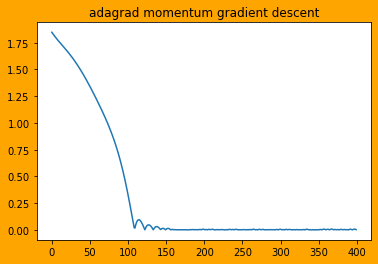

In [26]:
def adam(loss,grad,alpha,a,b,c,d,ma,mb,mc,md,va,vb,vc,vd,i,beta1=0.9,beta2=0.999,epsilon=1e-8):
    ga, gb, gc, gd = grad(a,b,c,d)
    ma = beta1*ma+(1-beta1)*ga
    mb = beta1*mb+(1-beta1)*gb
    mc = beta1*mc+(1-beta1)*gc
    md = beta1*md+(1-beta1)*gd
    va = beta2*va+(1-beta2)*ga**2
    vb = beta2*vb+(1-beta2)*gb**2
    vc = beta2*vc+(1-beta2)*gc**2
    vd = beta2*vd+(1-beta2)*gd**2
    corr_ma = ma/(1-beta1**(i+1))
    corr_mb = mb/(1-beta1**(i+1))
    corr_mc = mc/(1-beta1**(i+1))
    corr_md = md/(1-beta1**(i+1))
    corr_va = va/(1-beta2**(i+1))
    corr_vb = vb/(1-beta2**(i+1))
    corr_vc = vc/(1-beta2**(i+1))
    corr_vd = vd/(1-beta2**(i+1))
    a = a-alpha*corr_ma/(corr_va**0.5+epsilon)
    b = b-alpha*corr_mb/(corr_vb**0.5+epsilon)
    c = c-alpha*corr_mc/(corr_vc**0.5+epsilon)
    d = d-alpha*corr_md/(corr_vd**0.5+epsilon)
    return a,b,c,d,ma,mb,mc,md,va,vb,vc,vd

a, b, c, d = 1, 2, 3, 4
va, vb, vc, vd = 0, 0, 0, 0
ma, mb, mc, md = 0, 0, 0, 0
alpha = 1e-2
lossL = []
for i in range(400):
    l0 = loss(a,b,c,d)
    lossL.append(l0)
    if i%10==0:
        print(f"i={i}, a={round(a,5)}, b={round(b,5)}, c={round(c,5)}, d={round(d,5)}, loss={round(l0,5)}")
    a,b,c,d,ma,mb,mc,md,va,vb,vc,vd = adam(loss,grad,alpha,a,b,c,d,ma,mb,mc,md,va,vb,vc,vd,i) # new va,vb,i,m

ax = plt.figure()
ax.set_facecolor("orange")
plt.title("adagrad momentum gradient descent") 
plt.plot(lossL)
plt.show()

In [27]:
loss(a,b,c,d,printV=True)

A=[[-0.27142696  1.70344549]
 [ 1.70344549  3.24886972]], B=[[1.        ]
 [2.50319442]]
realX=[[0.39194546]
 [0.91998846]]
mypredX=[[0.3722137 +8.74579160e-18j]
 [0.92814706+3.53889356e-17j]], qkpredX=[[ 0.91897157]
 [-0.3943238 ]]
(myfp,myfn)=(0.9997720474101801,0.9997720474101801), (qkfp,qkfn)=(0.002586611387689107,0.002586611387689107)


0.0028145639775089978

### DEBUG

In [154]:
# A=np.array([[pi,-pi/2],[-pi/2,pi]]) B=|+> or |->
sp = np.array([[2**-0.5],[2**-0.5]])
sn = np.array([[2**-0.5],[-2**-0.5]])
print("+ stateAfterQPE:\n", mKron(s0,s0,s1,sp))
print("- stateAfterQPE:\n", mKron(s0,s1,s1,sn))

+ stateAfterQPE:
 [[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
- stateAfterQPE:
 [[ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]]


In [155]:
print("+ stateAfterCR:\n", mKron( (1-1/(2*pi*0.25)**2)**0.5 *s0, s0, s1, sp ) + mKron( 1/(2*pi*0.25)*s1, s0, s1, sp ) )
print("- stateAfterCR:\n", mKron( (1-1/(2*pi*0.75)**2)**0.5 *s0, s1, s1, sn ) + mKron( 1/(2*pi*0.75)*s1, s1, s1, sn ) )

+ stateAfterCR:
 [[0.        ]
 [0.        ]
 [0.54530508]
 [0.54530508]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.45015816]
 [0.45015816]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
- stateAfterCR:
 [[ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.6910023 ]
 [-0.6910023 ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.15005272]
 [-0.15005272]]


In [156]:
print("+ stateAfterIQPE:\n", mKron( (1-1/(2*pi*0.25)**2)**0.5 *s0, s0, s0, sp ) + mKron( 1/(2*pi*0.25)*s1, s0, s0, sp ) )
print("+ stateAfterIQPE:\n", mKron( (1-1/(2*pi*0.75)**2)**0.5 *s0, s0, s0, sn ) + mKron( 1/(2*pi*0.75)*s1, s0, s0, sn ) )

+ stateAfterIQPE:
 [[0.54530508]
 [0.54530508]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.45015816]
 [0.45015816]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
+ stateAfterIQPE:
 [[ 0.6910023 ]
 [-0.6910023 ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.15005272]
 [-0.15005272]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]
 [-0.        ]]


In [157]:
# CR debug
# CR 01
mKron(np.array([[(1-1/((2*pi*0.25)**2))**0.5],[1/(2*pi*0.25)]]), s0, s1)

array([[0.        ],
       [0.77117784],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.63661977],
       [0.        ],
       [0.        ]])

In [158]:
# CR 10
mKron(np.array([[(1-1/((2*pi*0.5)**2))**0.5],[1/(2*pi*0.5)]]), s1, s0)

array([[0.        ],
       [0.        ],
       [0.94798672],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.31830989],
       [0.        ]])

In [159]:
# CR 11
mKron(np.array([[(1-1/((2*pi*0.75)**2))**0.5],[1/(2*pi*0.75)]]), s1, s1)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.97722483],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.21220659]])